In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
from urllib.parse import urljoin, urlparse
import json
import re
from datetime import datetime
import logging
import ast
import numpy as np

In [15]:
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/138.0.0.0 Safari/537.36',
    'Accept-Language': 'de-DE,de;q=0.9'
}


In [4]:
# Initialize the enhanced scraper
scraper = EnhancedProteinScraper()

# First, get the main product listings
print("🚀 Scraping main product listings...")
total_products = scraper.scrape_main_pages(start_page=1, max_pages=5)

# Check the products with the correct column names
products_df = scraper.to_dataframe()
print(f"✅ Found {len(products_df)} products")

if not products_df.empty:
    print(f"\n📊 Available columns: {list(products_df.columns)}")
    
    # Display with the actual column names that exist
    display_columns = ['title', 'brand', 'price_per_100g_protein', 'price_per_100g', 'product_tags']
    
    # Check which columns actually exist
    existing_columns = [col for col in display_columns if col in products_df.columns]
    
    print(f"\n🎯 Sample data:")
    display(products_df[existing_columns].head())
    
    # Show nutrition and ingredient data if available
    if 'nutrition_info' in products_df.columns:
        print(f"\n🥗 Sample nutrition data:")
        print(products_df['nutrition_info'].iloc[0])
    
    if 'ingredients' in products_df.columns:
        print(f"\n📋 Sample ingredients data:")
        print(products_df['ingredients'].iloc[0])
        
    # Show the URLs we can use for price history
    if 'muchproteins_url' in products_df.columns:
        print(f"\n🔗 Sample URLs for price history:")
        for i, url in enumerate(products_df['muchproteins_url'].head(3)):
            print(f"  {i+1}. https://muchproteins.com{url}")
    
else:
    print("❌ No products found")

🚀 Scraping main product listings...
🚀 Starting to scrape pages 1 to 5...

📄 Scraping page 1: https://muchproteins.com
🎉 Found 25 products in data array!
✅ Found 25 products on page 1

📄 Scraping page 2: https://muchproteins.com/2
🎉 Found 25 products in data array!
✅ Found 25 products on page 2

📄 Scraping page 3: https://muchproteins.com/3
🎉 Found 25 products in data array!
✅ Found 25 products on page 3

📄 Scraping page 4: https://muchproteins.com/4
🎉 Found 25 products in data array!
✅ Found 25 products on page 4

📄 Scraping page 5: https://muchproteins.com/5
🎉 Found 3 products in data array!
✅ Found 3 products on page 5

🎉 Scraped 103 products total
✅ Found 103 products

📊 Available columns: ['source_page', 'scraped_at', 'extraction_method', 'title', 'product_url', 'brand', 'image_url', 'product_slug', 'ingredients', 'nutrition_info', 'product_tags', 'price_per_100g', 'price_per_100g_protein', 'price_summary', 'muchproteins_url']

🎯 Sample data:


,title,brand,price_per_100g_protein,price_per_100g,product_tags
0,Brown Rice Protein,Myprotein,1.64,1.28,"vegetarian, vegan, gluten free, dairy free, la..."
1,Vegan Pea Protein,ProteinWorks,1.91,1.45,"vegetarian, dairy free, lactose free, vegan, s..."
2,Impact Soy Protein,Myprotein,2.17,1.95,"vegetarian, vegan, dairy free, lactose free, g..."
3,Protein Hot Chocolate,Myprotein,2.19,1.25,"gluten free, vegetarian, dairy free, lactose f..."
4,Soya Protein Isolate,Bulk,2.35,2.00,"vegetarian, vegan, halal, dairy free, lactose ..."



🥗 Sample nutrition data:
{'': 'per 100 g', 'energy': {'kj': 1791, 'kcal': 423}, 'fat': {'all': 2.1, 'saturated': 0.4}, 'carbohydrates': {'all': 3.8, 'sugar': 1}, 'fibre': 8, 'protein': 78, 'salt': '&lt;0.01 g'}

📋 Sample ingredients data:
Brown Rice Protein, ['100%']

🔗 Sample URLs for price history:
  1. https://muchproteins.com/protein/brown-rice-protein
  2. https://muchproteins.com/protein/vegan-pea-protein
  3. https://muchproteins.com/protein/impact-soy-protein


In [5]:
products_df

,source_page,scraped_at,extraction_method,title,product_url,brand,image_url,product_slug,ingredients,nutrition_info,product_tags,price_per_100g,price_per_100g_protein,price_summary,muchproteins_url
0,1,2025-07-31T15:40:38.436932,muchproteins_json,Brown Rice Protein,https://www.myprotein.com/sports-nutrition/bro...,Myprotein,brown-rice-protein-bd2f322e5ecf2c762493321da79...,brown-rice-protein,"Brown Rice Protein, ['100%']","{'': 'per 100 g', 'energy': {'kj': 1791, 'kcal...","vegetarian, vegan, gluten free, dairy free, la...",1.28,1.64,"{'min': {'value': 21, 'grams': 2500, 'currency...",/protein/brown-rice-protein
1,1,2025-07-31T15:40:38.436974,muchproteins_json,Vegan Pea Protein,https://www.theproteinworks.com/pea-protein-80,ProteinWorks,vegan-pea-protein-ae7b3ed5345c44078d41443f9f64...,vegan-pea-protein,"Pea Protein Isolate, Fat-Reduced Cocoa Powder,...","{'energy': {'kj': 1676, 'kcal': 397}, 'fat': {...","vegetarian, dairy free, lactose free, vegan, s...",1.45,1.91,"{'min': {'value': 31.94, 'grams': 4000, 'curre...",/protein/vegan-pea-protein
2,1,2025-07-31T15:40:38.436994,muchproteins_json,Impact Soy Protein,https://www.myprotein.com/sports-nutrition/soy...,Myprotein,impact-soy-protein-f2e1487d426b05e2ca1ac39f13b...,impact-soy-protein,"Soy Protein Isolate, ['100%']","{'': 'of which sugars', 'energy': {'kj': 1505,...","vegetarian, vegan, dairy free, lactose free, g...",1.95,2.17,"{'min': {'value': 9.09, 'grams': 2500, 'curren...",/protein/impact-soy-protein
3,1,2025-07-31T15:40:38.437011,muchproteins_json,Protein Hot Chocolate,https://www.myprotein.com/sports-nutrition/pro...,Myprotein,protein-hot-chocolate-53d1ec0b0b3a1b8dbd0723e9...,protein-hot-chocolate,"Protein Blend, ['61%'], Cocoa Powder, Natural ...","{'': 'per 100g', 'energy': {'kj': 1419, 'kcal'...","gluten free, vegetarian, dairy free, lactose f...",1.25,2.19,"{'min': {'value': 8.7, 'grams': 1000, 'currenc...",/protein/protein-hot-chocolate
4,1,2025-07-31T15:40:38.437028,muchproteins_json,Soya Protein Isolate,https://www.bulk.com/eu/soya-protein-isolate-9...,Bulk,soya-protein-isolate-9ba460463064d661ea97d3a2c...,soya-protein-isolate,100% Soya Protein Isolate,"{'energy': {'kj': 1525, 'kcal': 364}, 'fat': {...","vegetarian, vegan, halal, dairy free, lactose ...",2.00,2.35,"{'min': {'value': 64.99, 'grams': 5000, 'curre...",/protein/soya-protein-isolate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,4,2025-07-31T15:40:46.236799,muchproteins_json,Egg White Protein 80,https://www.theproteinworks.com/egg-white-prot...,ProteinWorks,egg-white-protein-80-4e2a0e3f28965808f2a8027fa...,egg-white-protein-80,100% Egg White Powder,"{'energy': {'kj': 1456, 'kcal': 342}, 'fat': {...","vegetarian, soy free, gluten free",8.72,11.32,"{'min': {'value': 139.99, 'grams': 2000, 'curr...",/protein/egg-white-protein-80
99,4,2025-07-31T15:40:46.236818,muchproteins_json,Organic Master Blend Plant Based Protein For O...,https://www.vitaminshoppe.com/p/om-master-blen...,Om Organic Mushrooms,organic-master-blend-plant-based-protein-for-o...,organic-master-blend-plant-based-protein-for-o...,"Organic High Oleic Sunflower Oil Powder, ['Org...","{'energy': {'kj': 1741, 'kcal': 416}, 'fat': {...","vegetarian, dairy free, lactose free, vegan, s...",6.43,11.69,"{'min': {'value': 27.65, 'grams': 539, 'curren...",/protein/organic-master-blend-plant-based-prot...
100,5,2025-07-31T15:40:47.873839,muchproteins_json,Clear Diet Whey Protein,https://www.theproteinworks.com/clear-diet-whe...,ProteinWorks,clear-diet-whey-protein-cf2e102dde3a3d0fce6b1a...,clear-diet-whey-protein,"Whey Protein Isolate, ['Milk'], Citric Acid, F...","{'energy': {'kj': 1372, 'kcal': 328}, 'fat': {...","vegetarian, soy free, gluten free, WPI, whey",9.54,11.92,"{'min': {'value': 74.99, 'grams': 1000, 'curre...",/protein/clear-diet-whey-protein
101,5,2025-07-31T15:40:47.873958,muchproteins_json,Keto Friendly Plant Based Collagen with Hyalur...,https://www.vitaminshoppe.com/p/collagen-tahit...,SunWarrior,keto-friendly-

In [103]:
  # Save as CSV
products_df.to_csv('product_data.csv', index=False)

In [11]:
# Average prices by brand
brand_prices = df_final.groupby('brand').agg({
    'price_per_100g': ['mean', 'median', 'std', 'count'],
    'price_per_100g_protein': ['mean', 'median', 'std', 'count']
}).round(2)

# Sort by average price per 100g
brand_prices_sorted = brand_prices.sort_values(('price_per_100g', 'mean'), ascending=False)

In [25]:

brand_prices_sorted.to_csv('brand_prices_sorted.csv', index=False)

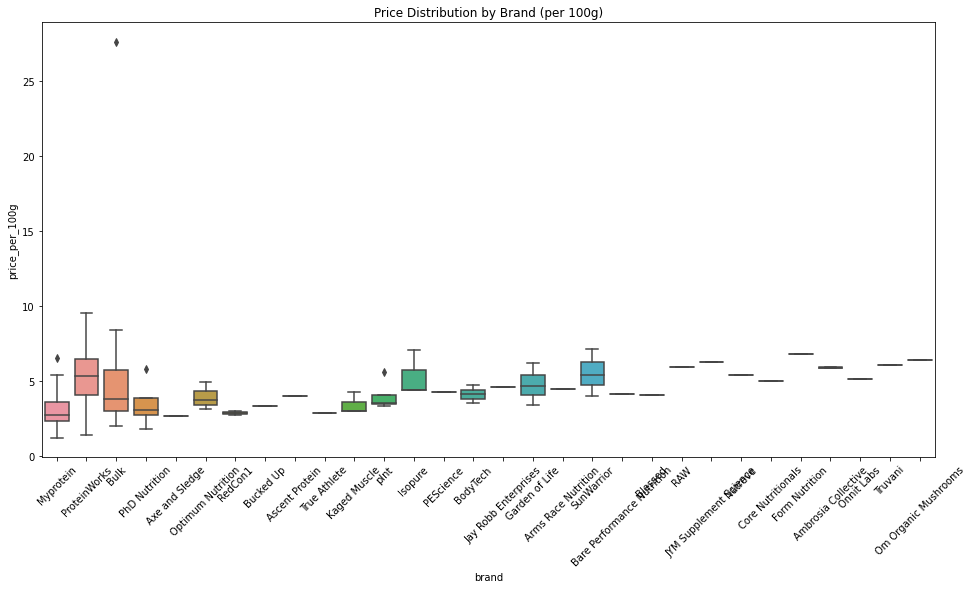

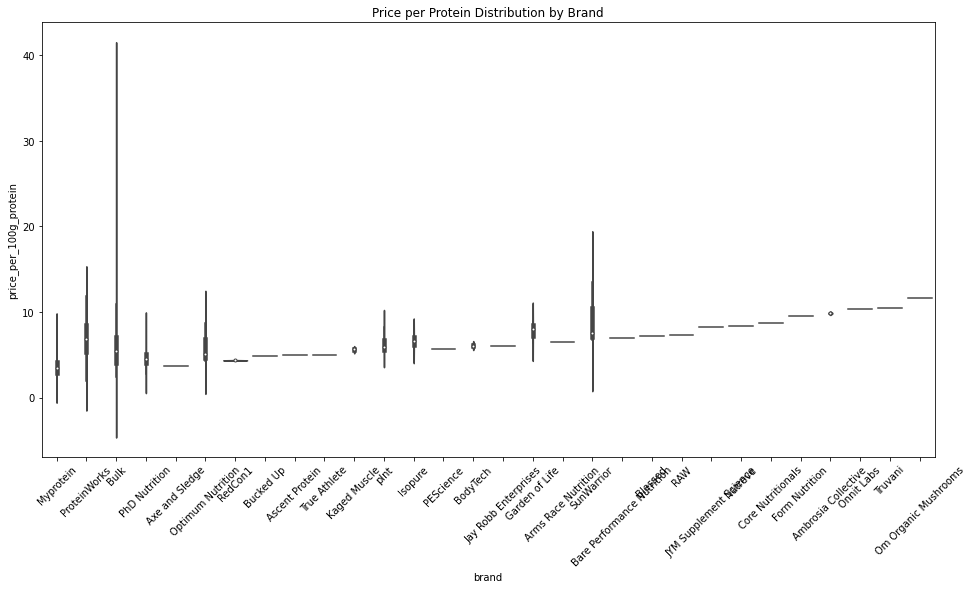

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plots to show price distribution by brand
plt.figure(figsize=(16, 8))
sns.boxplot(data=df_final, x='brand', y='price_per_100g')
plt.xticks(rotation=45)
plt.title('Price Distribution by Brand (per 100g)')
plt.show()



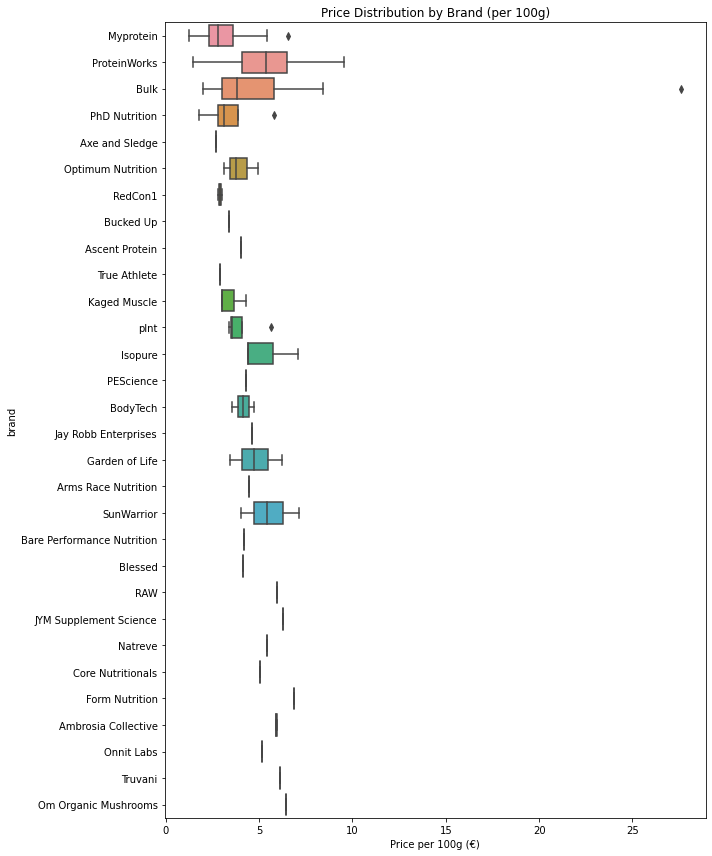

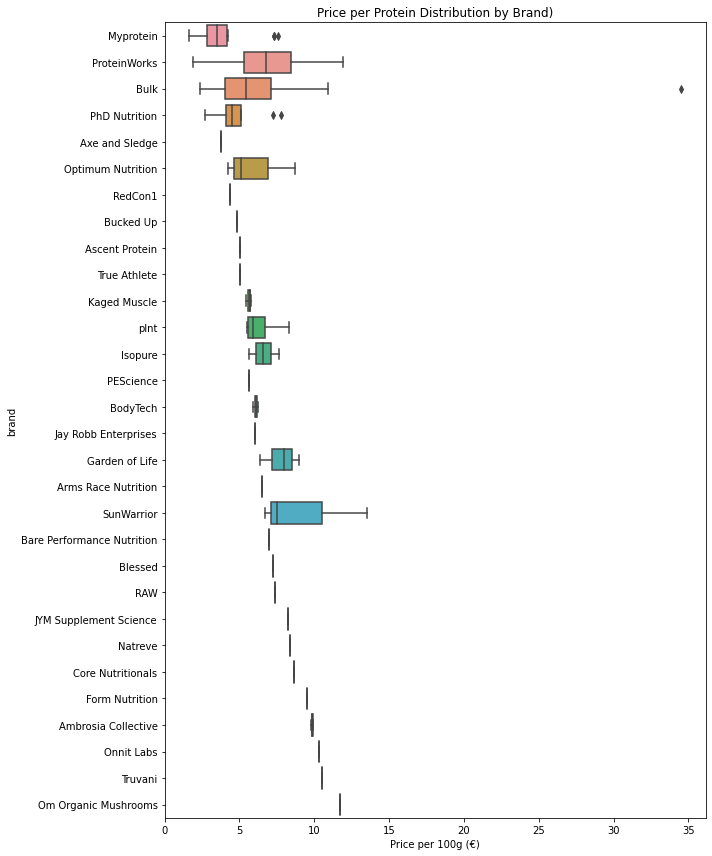

In [18]:
plt.figure(figsize=(10, 12))
sns.boxplot(data=df_final, y='brand', x='price_per_100g')
plt.title('Price Distribution by Brand (per 100g)')
plt.xlabel('Price per 100g (€)')
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 12))
sns.boxplot(data=df_final, y='brand', x='price_per_100g_protein')
plt.title('Price per Protein Distribution by Brand)')
plt.xlabel('Price per 100g (€)')
plt.tight_layout()
plt.show()


In [19]:
# Value-for-Money Analysis

# Create value score (lower is better value)
df_final['value_score'] = df_final['price_per_100g_protein']

# Best value brands
best_value = df_final.groupby('brand')['value_score'].mean().sort_values()
print("Best Value Brands (lowest price per 100g protein):")
4. Premium vs Budget Brand Analysisprint(best_value.head(10))

Best Value Brands (lowest price per 100g protein):
brand
Axe and Sledge       3.750000
Myprotein            3.988000
RedCon1              4.350000
PhD Nutrition        4.797778
Bucked Up            4.830000
True Athlete         5.020000
Ascent Protein       5.020000
Kaged Muscle         5.626667
PEScience            5.640000
Optimum Nutrition    5.996667
Name: value_score, dtype: float64


In [22]:
# 4. Premium vs Budget Brand Analysis

# Categorize brands by price range
price_quartiles = df_final['price_per_100g'].quantile([0.25, 0.5, 0.75])

def categorize_price(price):
    if price <= price_quartiles[0.25]:
        return 'Budget'
    elif price <= price_quartiles[0.75]:
        return 'Mid-range'
    else:
        return 'Premium'

df_final['price_category'] = df_final['price_per_100g'].apply(categorize_price)

# Count brands in each category
brand_categories = df_final.groupby('brand')['price_category'].agg(lambda x: x.mode()[0])
print(brand_categories.value_counts())

Mid-range    19
Premium       6
Budget        5
Name: price_category, dtype: int64


In [23]:
from scipy import stats

# Compare specific brands statistically
brand1_prices = df_final[df_final['brand'] == 'Myprotein']['price_per_100g']
brand2_prices = df_final[df_final['brand'] == 'Optimum Nutrition']['price_per_100g']

# T-test to see if price difference is significant
t_stat, p_value = stats.ttest_ind(brand1_prices, brand2_prices)
print(f"T-test p-value: {p_value}")

T-test p-value: 0.41778010013248434


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load the dataset

file_path = os.path.join('data', 'protein_data_categorized.csv')
df = pd.read_csv(file_path)


print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

# Define keywords for organic and GMO-free identification
organic_keywords = ['organic', 'organically', 'bio']
gmo_free_keywords = ['gmo free', 'non-gmo', 'non gmo', 'gmo-free']

def check_organic(row):
    """Check if product is organic based on ingredients and product_tags"""
    ingredients = str(row['ingredients']).lower() if pd.notna(row['ingredients']) else ''
    tags = str(row['product_tags']).lower() if pd.notna(row['product_tags']) else ''
    
    return any(keyword in ingredients or keyword in tags for keyword in organic_keywords)

def check_gmo_free(row):
    """Check if product is GMO-free based on ingredients and product_tags"""
    ingredients = str(row['ingredients']).lower() if pd.notna(row['ingredients']) else ''
    tags = str(row['product_tags']).lower() if pd.notna(row['product_tags']) else ''
    
    return any(keyword in ingredients or keyword in tags for keyword in gmo_free_keywords)

# Create new columns
print("\n" + "="*60)
print("CREATING NEW COLUMNS")
print("="*60)

df['organic_true'] = df.apply(check_organic, axis=1)
df['gmofree_true'] = df.apply(check_gmo_free, axis=1)

# Display products found
organic_products = df[df['organic_true']]
gmo_free_products = df[df['gmofree_true']]

print(f"\nOrganic products found ({len(organic_products)}):")
for idx, product in organic_products.iterrows():
    print(f"  - {product['product_name']}")

print(f"\nGMO-free products found ({len(gmo_free_products)}):")
for idx, product in gmo_free_products.iterrows():
    print(f"  - {product['product_name']}")

# Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

total_products = len(df)
organic_count = df['organic_true'].sum()
gmo_free_count = df['gmofree_true'].sum()
both_count = (df['organic_true'] & df['gmofree_true']).sum()

print(f"Total products: {total_products}")
print(f"Organic products: {organic_count} ({organic_count/total_products*100:.1f}%)")
print(f"GMO-free products: {gmo_free_count} ({gmo_free_count/total_products*100:.1f}%)")
print(f"Both organic AND GMO-free: {both_count}")
print(f"Regular products: {total_products - organic_count - gmo_free_count + both_count}")

# Price analysis
print("\n" + "="*60)
print("PRICE ANALYSIS")
print("="*60)

# Create category labels for analysis
def categorize_product(row):
    if row['organic_true'] and row['gmofree_true']:
        return 'Both'
    elif row['organic_true']:
        return 'Organic'
    elif row['gmofree_true']:
        return 'GMO-Free'
    else:
        return 'Regular'

df['category'] = df.apply(categorize_product, axis=1)

# Price per 100g analysis
price_stats = df.groupby('category')['price_per_100g'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

print("\nPrice per 100g by category:")
print(price_stats)

# Price per 100g protein analysis
protein_price_stats = df.groupby('category')['price_per_100g_protein'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

print("\nPrice per 100g protein by category:")
print(protein_price_stats)

# Statistical tests
print("\n" + "="*60)
print("STATISTICAL ANALYSIS")
print("="*60)

# T-tests comparing organic vs regular and gmo-free vs regular
organic_prices = df[df['organic_true']]['price_per_100g'].dropna()
regular_prices = df[~df['organic_true'] & ~df['gmofree_true']]['price_per_100g'].dropna()
gmo_free_prices = df[df['gmofree_true']]['price_per_100g'].dropna()

# Organic vs Regular
if len(organic_prices) > 0 and len(regular_prices) > 0:
    t_stat_org, p_val_org = stats.ttest_ind(organic_prices, regular_prices)
    print(f"\nOrganic vs Regular prices:")
    print(f"  Organic mean: €{organic_prices.mean():.2f}")
    print(f"  Regular mean: €{regular_prices.mean():.2f}")
    print(f"  Price difference: €{organic_prices.mean() - regular_prices.mean():.2f}")
    print(f"  Percentage premium: {((organic_prices.mean() / regular_prices.mean()) - 1) * 100:.1f}%")
    print(f"  T-test p-value: {p_val_org:.4f}")
    print(f"  Significant difference: {'Yes' if p_val_org < 0.05 else 'No'}")

# GMO-Free vs Regular
if len(gmo_free_prices) > 0 and len(regular_prices) > 0:
    t_stat_gmo, p_val_gmo = stats.ttest_ind(gmo_free_prices, regular_prices)
    print(f"\nGMO-Free vs Regular prices:")
    print(f"  GMO-Free mean: €{gmo_free_prices.mean():.2f}")
    print(f"  Regular mean: €{regular_prices.mean():.2f}")
    print(f"  Price difference: €{gmo_free_prices.mean() - regular_prices.mean():.2f}")
    print(f"  Percentage difference: {((gmo_free_prices.mean() / regular_prices.mean()) - 1) * 100:.1f}%")
    print(f"  T-test p-value: {p_val_gmo:.4f}")
    print(f"  Significant difference: {'Yes' if p_val_gmo < 0.05 else 'No'}")

# Create visualizations
print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# Set up the plotting area
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Protein Products: Organic and GMO-Free Impact on Pricing', fontsize=16, fontweight='bold')

# 1. Box plot of prices by category
ax1 = axes[0, 0]
df_plot = df[df['price_per_100g'].notna()]
sns.boxplot(data=df_plot, x='category', y='price_per_100g', ax=ax1)
ax1.set_title('Price per 100g by Category')
ax1.set_xlabel('Product Category')
ax1.set_ylabel('Price (€/100g)')
ax1.tick_params(axis='x', rotation=45)

# 2. Box plot of protein prices by category
ax2 = axes[0, 1]
df_plot_protein = df[df['price_per_100g_protein'].notna()]
sns.boxplot(data=df_plot_protein, x='category', y='price_per_100g_protein', ax=ax2)
ax2.set_title('Price per 100g Protein by Category')
ax2.set_xlabel('Product Category')
ax2.set_ylabel('Price (€/100g protein)')
ax2.tick_params(axis='x', rotation=45)

# 3. Count of products by category
ax3 = axes[1, 0]
category_counts = df['category'].value_counts()
bars = ax3.bar(category_counts.index, category_counts.values)
ax3.set_title('Number of Products by Category')
ax3.set_xlabel('Product Category')
ax3.set_ylabel('Number of Products')
ax3.tick_params(axis='x', rotation=45)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom')

# 4. Scatter plot: Price vs Protein content, colored by category
ax4 = axes[1, 1]
for category in df['category'].unique():
    cat_data = df[df['category'] == category]
    ax4.scatter(cat_data['protein'], cat_data['price_per_100g'], 
               label=category, alpha=0.7, s=50)

ax4.set_title('Price vs Protein Content by Category')
ax4.set_xlabel('Protein Content (g/100g)')
ax4.set_ylabel('Price (€/100g)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display sample of enhanced dataset
print("\n" + "="*60)
print("ENHANCED DATASET SAMPLE")
print("="*60)

print("\nNew columns added:")
print("- organic_true: Boolean indicating if product is organic")
print("- gmofree_true: Boolean indicating if product is GMO-free")
print("- category: Categorical label for analysis")

print(f"\nSample of enhanced dataset:")
sample_cols = ['product_name', 'price_per_100g', 'price_per_100g_protein', 
               'organic_true', 'gmofree_true', 'category']
print(df[sample_cols].head(10))

# Key findings summary
print("\n" + "="*60)
print("KEY FINDINGS SUMMARY")
print("="*60)

print("\n🔍 MAIN FINDINGS:")

if len(organic_prices) > 0 and len(regular_prices) > 0:
    org_premium = ((organic_prices.mean() / regular_prices.mean()) - 1) * 100
    print(f"• Organic products carry a {org_premium:.1f}% price premium")
    print(f"  (€{organic_prices.mean():.2f} vs €{regular_prices.mean():.2f} per 100g)")

if len(gmo_free_prices) > 0 and len(regular_prices) > 0:
    gmo_diff = ((gmo_free_prices.mean() / regular_prices.mean()) - 1) * 100
    if gmo_diff > 0:
        print(f"• GMO-free products carry a {gmo_diff:.1f}% price premium")
    else:
        print(f"• GMO-free products are {abs(gmo_diff):.1f}% cheaper than regular products")
    print(f"  (€{gmo_free_prices.mean():.2f} vs €{regular_prices.mean():.2f} per 100g)")

print(f"\n📊 DATASET COMPOSITION:")
print(f"• {organic_count} organic products ({organic_count/total_products*100:.1f}%)")
print(f"• {gmo_free_count} GMO-free products ({gmo_free_count/total_products*100:.1f}%)")
print(f"• {both_count} products with both certifications")

print(f"\n✅ ANALYSIS COMPLETE:")
print("• Enhanced dataset created with new boolean columns")
print("• Statistical analysis performed")
print("• Visualizations generated")
print("• Original data structure preserved")

# Save enhanced dataset
df.to_csv('protein_data_enhanced.csv', index=False)
print(f"\n💾 Enhanced dataset saved as 'protein_data_enhanced.csv'")
print(f"   Original columns: {len(df.columns) - 3}")
print(f"   New columns added: 3 (organic_true, gmofree_true, category)")
print(f"   Total columns: {len(df.columns)}")

FileNotFoundError: [Errno 2] No such file or directory: 'data/protein_data_categorized.csv'